# Demo of Build tools from SwiftPol

- Build a short linear co-polymer chain (PLGA)
- Create a small SwiftPol PLGA ensemble, assign partial charges to the chain, and inspect the chains in the system
- Solvate the PLGA ensemble with water, NaCl and residual monomer using [Packmol](https://m3g.github.io/packmol/)
- Parameterize the solvated ensemble and run a short NVT simulation using [OpenMM](https://github.com/openmm/openmm)

In [7]:
# Print SwiftPol Version
from swiftpol.__version__ import __version__
__version__

'0.1.4'

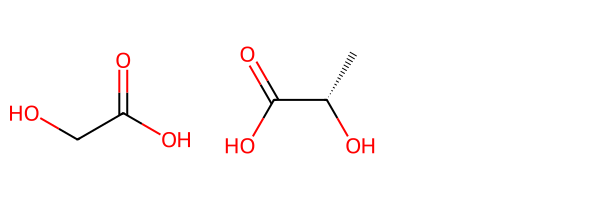

In [8]:
# Import monomers to build PLGA and visualise using RDkit
from rdkit import Chem
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*')   
monomer_smiles = ['OC(=O)CO', 'C[C@@H](C(=O)[OH])O']
glycolic = Chem.MolFromSmiles(monomer_smiles[0])
lactate = Chem.MolFromSmiles(monomer_smiles[1])
Chem.Draw.MolsToGridImage([glycolic,lactate])

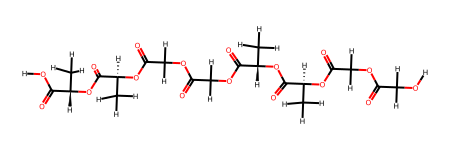

In [9]:
# Build a short blocky linear chain using Swiftpol
from swiftpol import build
from rdkit.Chem import AllChem
monomer_list = ['OC(=O)COI', 'C[C@@H](C(=O)[OH])OI']
reaction = AllChem.ReactionFromSmarts('[C:1][O:2][H:3].[I:4][O:5][C:6]>>[C:1][O:2][C:6].[H:3][O:5][I:4]')
chain = build.build_polymer(sequence = 'AABBAABB',
                            monomer_list= monomer_list,
                            reaction = reaction)
chain

In [10]:
# Build a PLGA system
# Note: This polymer system is small, to facilitate a fast workflow demo, therefore some parameters (chain length, residual monomer) may not be close to input
# PLGA is composed of diblock lactide and glycolide monomers. To recreate this, set diblock=True
polymer = build.polymer_system(monomer_list=['O[C@H](C)C(=O)O[I]', 'OCC(=O)O[I]'], 
                               reaction='[C:1][O:2][H:3].[I:4][O:5][C:6]>>[C:1][O:2][C:6].[H:3][O:5][I:4]',
                               length_target=10, 
                               terminals='ester', 
                               num_chains=10,
                               perc_A_target=74.3,
                               blockiness_target=[1.0, 'B'], 
                               copolymer=True,
                               diblock=True,
                               acceptance=20)

System built!, size = 10


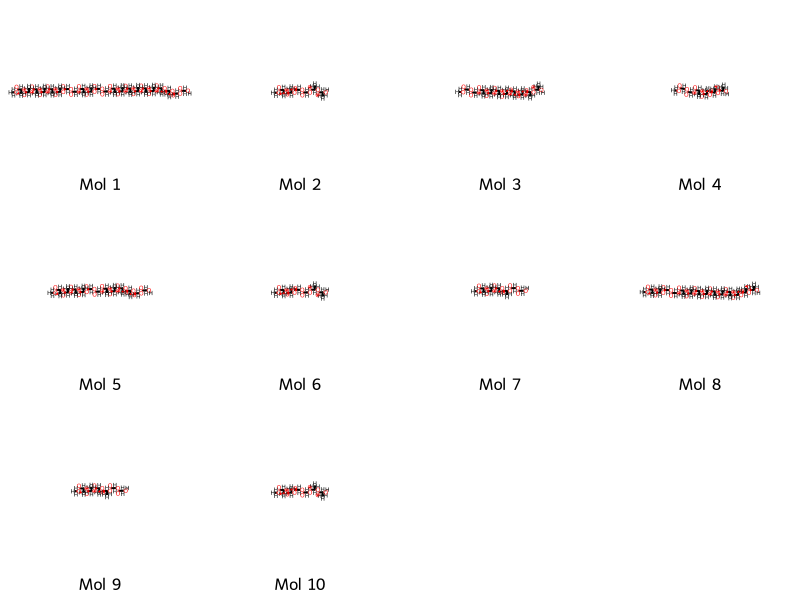

In [11]:
# Generate a grid image of the molecules
from rdkit.Chem import Draw
Draw.MolsToGridImage(
    polymer.chain_rdkit,
    molsPerRow=4,  # Number of molecules per row
    subImgSize=(200, 200),  # Size of each molecule image
    legends=[f"Mol {i+1}" for i in range(len(polymer.chain_rdkit))]  # Optional legends
)

In [12]:
# Calculate the polydispersity index of the PLGA system
PDI = build.PDI(polymer.chain_rdkit)[0]
print('PDI = ', round(PDI,2))

PDI =  1.27


In [13]:
# Calculate the blockiness of the sequence
from swiftpol import build
mean_blockiness, G_block_length, L_block_length = build.blockiness_gen(sequence=polymer.sequence, wrt='B')
print("Average chain blockiness =", round(mean_blockiness,1))
print("G Block length =", round(G_block_length))
print("L Block length =", round(L_block_length))

Average chain blockiness = 1.0
G Block length = 2
L Block length = 2


In [14]:
# Generate conformers and inspect first chain in 3D (requires nglview)
polymer.generate_conformers(rough=True)
polymer.chains[0].visualize('nglview')

/Users/hannahturney/Library/CloudStorage/OneDrive-King'sCollegeLondon/Hannah/PhD/SwiftPol/swiftpol/build.py:1062: UserWarning: Rough coordinates have been generated. Any charges previously applied to the system.chains attributewill need to be reapplied.
  warn(


NGLWidget()

In [15]:
# Charge the PLGA system using OpenFF NAGL 
polymer.charge_system('NAGL')

The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html


In [16]:
# Use the OpenFF Packmol Wrapper to solvate the chains
# Example of using existing tools to prepare SwiftPol chains for Molecular Dynamics
from openff.units import unit
molecules, number_of_copies, topology, box_vectors, residual_monomer_actual = build.calculate_box_components(chains = polymer.chains, 
                                                                                                       monomers = monomer_smiles, 
                                                                                                       sequence = polymer.sequence, 
                                                                                                       salt_concentration= 1 * unit.mole/unit.litre,
                                                                                                       residual_monomer = 10)
import openff.interchange.components._packmol as packmol_wrapper
import os
solvated_top = packmol_wrapper.pack_box(molecules = molecules + polymer.chains,
                                        number_of_copies = number_of_copies+[1 for i in range(len(polymer.chains))],
                                        box_vectors = box_vectors,
                                        tolerance = 1*unit.angstrom,
                                        working_directory=os.getcwd())
solvated_top.visualize()

NGLWidget()

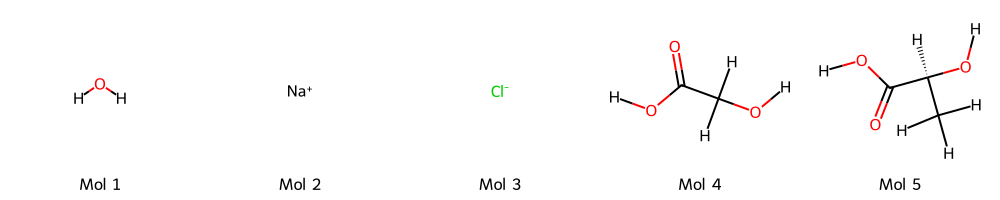

In [17]:
# Inspect what we have added to the box - water, NaCl and residual monomer
molecules_rd = [mol.to_rdkit() for mol in molecules]
from rdkit.Chem import Draw
Draw.MolsToGridImage(
    molecules_rd,
    molsPerRow=5,  # Number of molecules per row
    subImgSize=(200, 200),  # Size of each molecule image
    legends=[f"Mol {i+1}" for i in range(len(polymer.chain_rdkit))]  # Optional legends
)

In [18]:
# Perform the same function using the SwiftPol ensemble class function
solvated_top_swiftpol = polymer.pack_solvated_system(salt_concentration= 1 * unit.mole/unit.litre, residual_monomer = 10)
print(f'residual monomer = {round(polymer.residual_monomer_actual,2)}%')
solvated_top_swiftpol.visualize()

residual monomer = 7.73%


NGLWidget()

### Now we have a solvated polymer, let's assign parameters from the [OpenFF Sage Force Field](https://openforcefield.org/force-fields/force-fields/) and perform a short NVT ensemble simulation

In [21]:
# Parameterize the polymer and water using OpenFF interchange
# Since we previously assigned partial charges using OpenFF Nagl, we don't have to perform charge assignment for our polymer chains
from openff.interchange import Interchange
from openff.toolkit.typing.engines.smirnoff import ForceField
parameterized_system = Interchange.from_smirnoff(topology = solvated_top,
                                                force_field=ForceField("openff-2.2.0.offxml"), 
                                                charge_from_molecules=list(set(polymer.chains)))

In [ ]:
# Export the parameterized system to OpenMM, perform energy minimization and run a short simulation
import openmm

# Integration settings
time_step = 2 * openmm.unit.femtoseconds  # simulation timestep
temperature = 298 * openmm.unit.kelvin  # simulation temperature - RT
friction = 1 / openmm.unit.picosecond  # friction constant

# Initiate Langevin Integrator
integrator = openmm.LangevinIntegrator(temperature, friction, time_step)

# Create simulation from interchange file and Langevin integrator
simulation = parameterized_system.to_openmm_simulation(integrator=integrator)

state = simulation.context.getState(getPositions=True, getEnergy=True)
print(f'Energy before minimization = {state.getPotentialEnergy()}')
simulation.minimizeEnergy()

state = simulation.context.getState(getPositions=True, getEnergy=True)
print(f'Energy after minimization = {state.getPotentialEnergy()}')


Energy before minimization = 100954184.20800412 kJ/mol


In [33]:
# Add some reporters so we can save simulation progress
pdb_reporter = openmm.app.PDBReporter("trajectory_pdb.pdb", 10)
dcd_reporter = openmm.app.DCDReporter("trajectory_dcd.dcd", 10)
state_data_reporter = openmm.app.StateDataReporter(
    "data_prod.csv",
    reportInterval=10,
    step = True,             # writes the step number to each line
    time = True,             # writes the time (in ps)
    potentialEnergy = True,  # writes potential energy of the system (KJ/mole)
    kineticEnergy = True,    # writes the kinetic energy of the system (KJ/mole)
    totalEnergy = True,      # writes the total energy of the system (KJ/mole)
    temperature = True,      # writes the temperature (in K)
    volume = True,           # writes the volume (in nm^3)
    density = True)         # writes the density (in g/mL)

simulation.reporters.append(pdb_reporter)
simulation.reporters.append(dcd_reporter)
simulation.reporters.append(state_data_reporter)

In [34]:
#Simulation
import time
num_steps = 100  # number of steps to run - increase this value to run a longer simulation

print("Starting simulation...")
start = time.process_time()

# Run the simulation
simulation.step(num_steps)

end = time.process_time()
print(f"Elapsed time {end - start} seconds")
print("Done!")

Starting simulation...
Elapsed time 0.6512230000000017 seconds
Done!


### Analysis - Let's look at our simulation!
Note: Requires [MDAnalysis](https://docs.mdanalysis.org/2.0.0/index.html), a useful package for analyzing MD simulations, and nglview for visualization. This step is not essential for running this demo notebook, and MDAnalysis is not a dependency of SwiftPol.
To install MDAnalysis and nglview, run the next cell

In [35]:
!pip install MDAnalysis
!pip install nglview

In [36]:
# Create MDAnalysis Universe
import MDAnalysis as mda
universe = mda.Universe("trajectory_pdb.pdb", "trajectory_dcd.dcd")

/opt/anaconda3/envs/swiftpol/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [37]:
# Adjust visualization settings for water
import nglview
view = nglview.show_mdanalysis(universe)
view.add_representation('line',selection="water")
# Take a look at the whole simulation
view

NGLWidget(max_frame=9)